In [22]:
import pandas as pd
import cellrank as cr
import scanpy as sc
import os
import pandas as pd
from tqdm import tqdm
import palantir
import numpy as np
from cellrank.estimators import GPCCA
import scipy.sparse
import matplotlib.pyplot as plt
from cellrank.kernels import ConnectivityKernel, PseudotimeKernel

In [2]:
def preprocess_time_series_data(
    adata, time_col="development_stage", celltype_col="cell_type"
):
    """
    Comprehensive preprocessing pipeline for time series single-cell data with multiple cell types.

    Parameters:
    - time_col: column name for time points/development stages
    - celltype_col: column name for cell types
    """

    print("Starting preprocessing pipeline...")
    print(f"Data shape: {adata.shape}")

    # 1. Quality Control
    print("\n1. Quality Control...")

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=[], percent_top=None, log1p=False, inplace=True
    )

    # Filter cells: minimum genes, maximum mitochondrial percentage
    sc.pp.filter_cells(adata, min_genes=200)
    adata = adata[adata.obs.n_genes_by_counts < 5000]  # Remove potential doublets

    # Filter genes: minimum cells
    sc.pp.filter_genes(adata, min_cells=10)

    print(f"After QC: {adata.shape}")

    # 2. Normalization and Log Transformation
    print("\n2. Normalization...")
    sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize to 10,000 counts per cell
    sc.pp.log1p(adata)  # Log transform

    # 3. Feature Selection
    print("\n3. Feature Selection...")
    sc.pp.highly_variable_genes(
        adata, n_top_genes=3000, subset=False, flavor="seurat_v3"
    )

    # Keep highly variable genes
    adata = adata[:, adata.var.highly_variable]
    print(f"After HVG selection: {adata.shape}")

    # 4. Scale the data
    print("\n4. Scaling...")
    sc.pp.scale(adata, max_value=10)  # Scale to max value of 10

    # 5. Dimensionality Reduction
    print("\n5. PCA...")
    sc.tl.pca(adata, n_comps=50, svd_solver="arpack")

    # 6. Use Raw PCA (No Batch Correction)
    print("\n6. Using raw PCA (no batch correction)")
    use_rep = "X_pca"

    # 7. Neighborhood Graph and Clustering
    print("\n7. Computing Neighborhood Graph...")
    sc.pp.neighbors(adata, n_neighbors=30, use_rep=use_rep)

    print("Computing UMAP...")
    sc.tl.umap(adata)

    print("Clustering...")
    sc.tl.leiden(adata, resolution=1.0)

    # 8. Optional: Cell Type Annotation (if not already present)
    if celltype_col not in adata.obs.columns or adata.obs[celltype_col].isna().any():
        print("\n8. Cell Type Annotation needed...")
        # You might want to use automated annotation tools like:
        # - sc.tl.rank_genes_groups() for marker genes
        # - External reference datasets
        # - Pre-trained models
        print(
            "Consider using marker genes or reference datasets for cell type annotation"
        )

    # 9. Setup for Trajectory Analysis
    print("\n9. Preparing for Trajectory Analysis...")

    # Add time point ordering for trajectory analysis
    if time_col in adata.obs.columns:
        # Create numerical time ordering if time points are categorical
        time_stages = adata.obs[time_col].unique()
        time_order = {stage: i for i, stage in enumerate(sorted(time_stages))}
        adata.obs["time_order"] = adata.obs[time_col].map(time_order)
        print(f"Time stages found: {time_stages}")

    print("Preprocessing completed!")
    print(f"Final data shape: {adata.shape}")
    print(f"Variables in obs: {list(adata.obs.columns)}")

    return adata

In [ ]:
def visualize_preprocessing(adata, time_col='development_stage', celltype_col='cell_type'):
    """Create diagnostic plots for preprocessed data"""
    
    # Set up plotting
    import matplotlib.pyplot as plt
    sc.set_figure_params(dpi=100, figsize=(6, 6))
    
    # UMAP colored by time points
    if time_col in adata.obs.columns:
        sc.pl.umap(adata, color=time_col, title="UMAP by Time Points", save='_time_points.png')
    
    # UMAP colored by cell types (if available)
    if celltype_col in adata.obs.columns:
        sc.pl.umap(adata, color=celltype_col, title="UMAP by Cell Types", save='_cell_types.png')
    
    # UMAP colored by clusters
    sc.pl.umap(adata, color='leiden', title="UMAP by Clusters", save='_clusters.png')
    
    # QC metrics
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].hist(adata.obs['n_genes_by_counts'], bins=50)
    axes[0].set_title('Number of Genes per Cell')
    axes[0].set_xlabel('Genes')
    axes[0].set_ylabel('Cells')
    
    axes[1].hist(adata.obs['total_counts'], bins=50)
    axes[1].set_title('Total Counts per Cell')
    axes[1].set_xlabel('Total Counts')
    
    axes[2].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], alpha=0.5, s=1)
    axes[2].set_title('Counts vs Genes')
    axes[2].set_xlabel('Total Counts')
    axes[2].set_ylabel('Number of Genes')
    
    plt.tight_layout()
    plt.savefig('plots/qc_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

In [6]:
def pseudotime(adata,early_cell='10X83_2_AAACTCAGGGTATG-'):    
    # Use harmonized PCA if available, otherwise raw PCA
    pca_key = "X_pca_harmony" if "X_pca_harmony" in adata.obsm else "X_pca"
    pca_df = pd.DataFrame(adata.obsm[pca_key], index=adata.obs_names)
    
    pr_res = palantir.core.run_palantir(pca_df, early_cell=early_cell, num_waypoints=500)

    # Add pseudotime to obs
    adata.obs['palantir_pseudotime'] = pr_res.pseudotime

    # ✅ Correct: Store waypoints in `uns`, not `obsm`
    adata.uns['palantir_waypoints'] = pr_res.waypoints

    # Visualize pseudotime
    sc.pl.umap(adata, color='palantir_pseudotime')
    return adata

In [7]:
adata = sc.read("/tank/projects/etadevosyan_aging/brain_aging/GSE104323_processed.h5ad")
subset = adata[adata.obs["characteristics: cell cluster"]=='Immature-Pyr']
subset = subset[subset.obs["characteristics: age"].isin(['E16.5','P0','P5','P23'])]
adata_result = preprocess_time_series_data(
    subset, "characteristics: age", "characteristics: cell cluster"
)


Starting preprocessing pipeline...
Data shape: (4518, 27933)

1. Quality Control...


/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scanpy/preprocessing/_qc.py:145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


After QC: (4496, 14265)

2. Normalization...

3. Feature Selection...


/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After HVG selection: (4496, 3000)

4. Scaling...

5. PCA...


/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)



6. Using raw PCA (no batch correction)

7. Computing Neighborhood Graph...
Computing UMAP...
Clustering...

9. Preparing for Trajectory Analysis...
Time stages found: ['E16.5', 'P0', 'P5', 'P23']
Categories (4, object): ['E16.5', 'P0', 'P5', 'P23']
Preprocessing completed!
Final data shape: (4496, 3000)
Variables in obs: ['source name', 'organism', 'characteristics: strain', 'characteristics: age', 'characteristics: sex of pooled animals', 'characteristics: cell cluster', 'molecule', 'SRR run accession', 'raw file (original file name)', 'UMI_CellularBarcode', 'n_genes_by_counts', 'total_counts', 'n_genes', 'leiden', 'time_order']


Sampling and flocking waypoints...
Time for determining waypoints: 0.002551289399464925 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.11383732159932454 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.7550
Correlation at iteration 2: 0.9988
Correlation at iteration 3: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


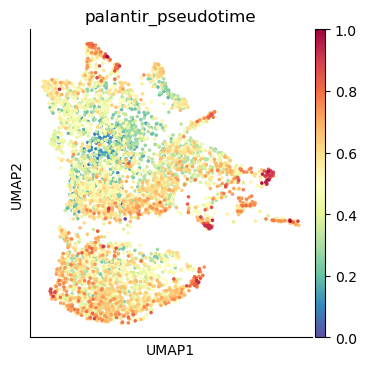

In [8]:
pseudotime_df = pseudotime(adata_result)

In [ ]:
def run_cellrank_analysis(adata, save_plots=True, plot_dir="./plots/cellrank_plots"):
    """
    Run CellRank analysis with plot saving functionality.
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data object
    save_plots : bool
        Whether to save plots to files
    plot_dir : str
        Directory to save plots
    
    Returns:
    --------
    GPCCA object
        The fitted GPCCA object
    """

    
    # Create plot directory if saving plots
    if save_plots:
        os.makedirs(plot_dir, exist_ok=True)
        print(f"Plots will be saved to: {plot_dir}")
    
    # Compute kernels
    print("Computing kernels...")
    ck = ConnectivityKernel(adata).compute_transition_matrix()
    pk = PseudotimeKernel(adata, time_key="palantir_pseudotime").compute_transition_matrix()
    combined_kernel = 0.8 * pk + 0.2 * ck
    
    # Initialize GPCCA
    print("Running GPCCA...")
    g = GPCCA(combined_kernel)
    g.fit(n_states=20, cluster_key="leiden")
    
    # Plot all macrostates
    print("Plotting all macrostates...")
    g.plot_macrostates(which="all",save=plot_dir,dpi=150)
    # Predict terminal states
    print("Predicting terminal states...")
    g.predict_terminal_states()
    
    # Plot terminal states
    print("Plotting terminal states...")
    g.plot_macrostates(which="terminal",save=plot_dir,dpi=150)
    
    # Compute fate probabilities
    print("Computing fate probabilities...")
    g.compute_fate_probabilities()
    
    # Plot fate probabilities
    print("Plotting fate probabilities...")
    g.plot_fate_probabilities(legend_loc="right",save=plot_dir,dpi=150)
    
    # Circular projection
    print("Creating circular projection...")
    cr.pl.circular_projection(adata, keys="leiden", legend_loc="right",save=plot_dir,dpi=150)
    
    # Plot fate probabilities again (as in original)
    print("Plotting fate probabilities (second plot)...")
    g.plot_fate_probabilities(legend_loc="right",save=plot_dir,dpi=150)
    
    print("CellRank analysis completed!")
    if save_plots:
        print(f"All plots saved to: {plot_dir}")
    
    return g
    

Plots will be saved to: ./plots/cellrank_plots
Computing kernels...


100%|██████████| 4496/4496 [00:04<00:00, 956.73cell/s] 


Running GPCCA...
Plotting all macrostates...


/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


saving figure to file ./plots/cellrank_plots.pdf


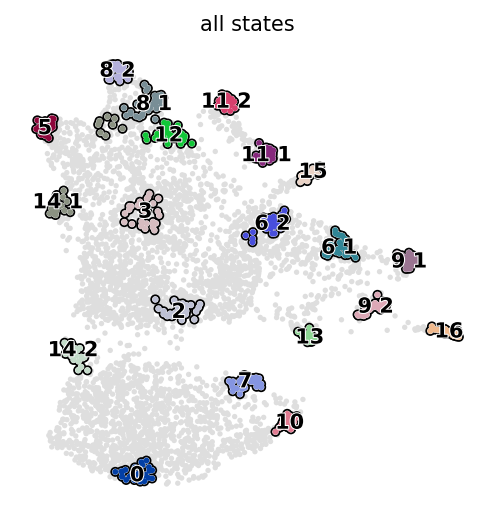

Predicting terminal states...
Plotting terminal states...


/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


saving figure to file ./plots/cellrank_plots.pdf


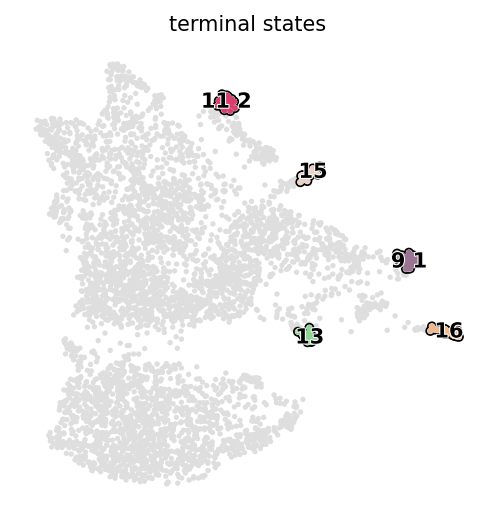

Computing fate probabilities...


100%|██████████| 5/5 [00:00<00:00, 10.32/s]
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


Plotting fate probabilities...


/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./plots/cellrank_plots.pdf


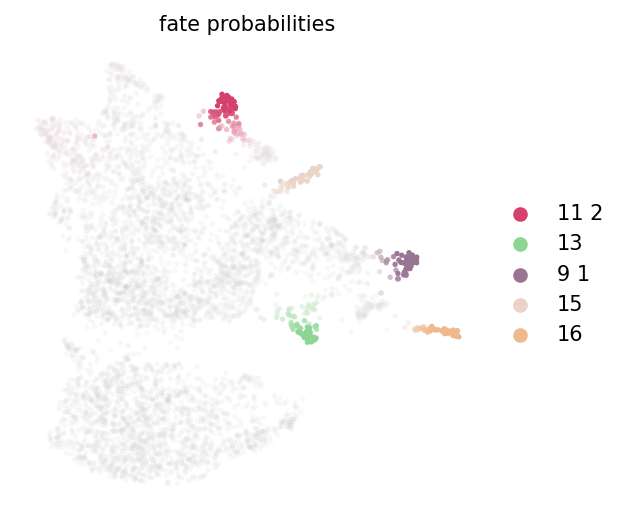

Creating circular projection...
Plotting fate probabilities (second plot)...


/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./plots/cellrank_plots.pdf


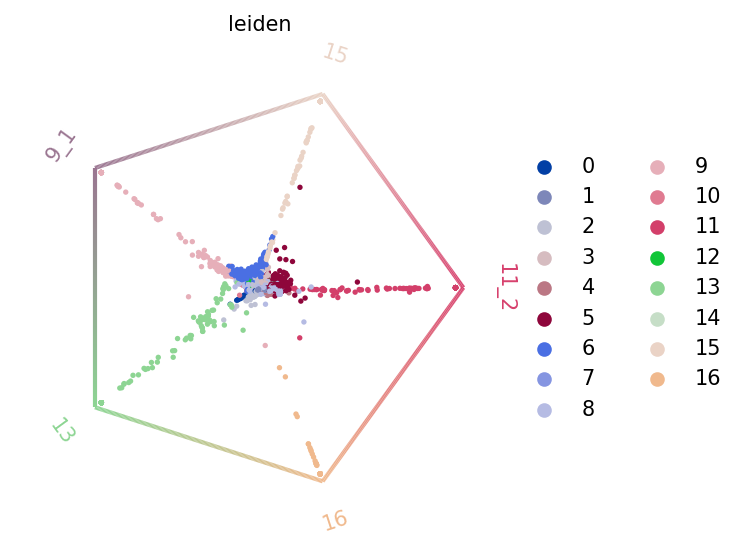

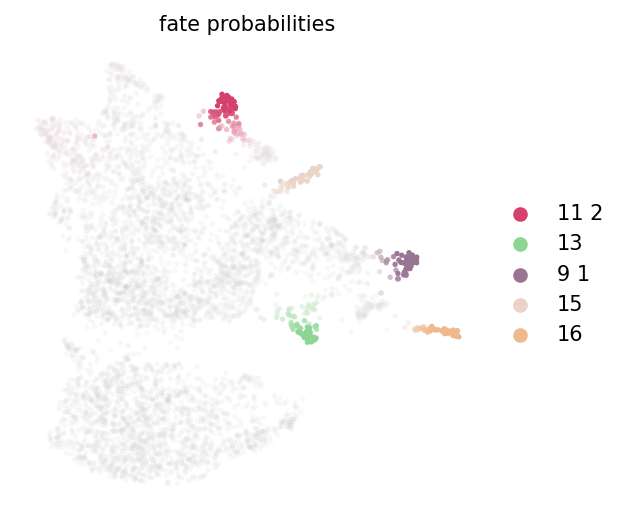

CellRank analysis completed!
All plots saved to: ./plots/cellrank_plots


In [33]:
results = run_cellrank_analysis(pseudotime_df)

In [34]:
results.predict_terminal_states()

GPCCA[kernel=(0.8 * PseudotimeKernel[n=4496] + 0.2 * ConnectivityKernel[n=4496]), initial_states=None, terminal_states=[np.str_('0'), np.str_('11_2'), np.str_('13'), np.str_('15'), np.str_('16'), np.str_('8_2'), np.str_('9_1')]]

/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/etadevosyan/.conda/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


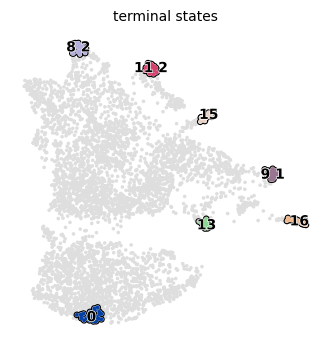

In [35]:
results.plot_macrostates(which="terminal")

In [36]:
pseudotime_df

AnnData object with n_obs × n_vars = 4496 × 3000
    obs: 'source name', 'organism', 'characteristics: strain', 'characteristics: age', 'characteristics: sex of pooled animals', 'characteristics: cell cluster', 'molecule', 'SRR run accession', 'raw file (original file name)', 'UMI_CellularBarcode', 'n_genes_by_counts', 'total_counts', 'n_genes', 'leiden', 'time_order', 'palantir_pseudotime', 'macrostates_fwd', 'clusters_gradients', 'term_states_fwd', 'term_states_fwd_probs'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'palantir_waypoints', 'schur_matrix_fwd', 'eigendecomposition_fwd', 'macrostates_fwd_colors', 'clusters_gradients_colors', 'leiden_colors', 'trajectory_analysis', 'coarse_fwd', 'term_states_fwd_colors'
    obsm: 'X_pca', 'X_umap', 'schur_vectors_fwd', 'macrostates